In [75]:
import os
import sys
from functools import partial

import ase
import numpy as np
from ase.io import read, write
from matplotlib import pyplot as plt
import matplotlib as mpl
from openTSNE import TSNE
from rascal.representations import SphericalInvariants as SOAP
from skcosmo.preprocessing import StandardFlexibleScaler
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import normalize
import sklearn.cluster as cluster
import seaborn as sns
from tqdm.auto import tqdm
import hdbscan

from utils import set_mpl_fonts, set_cmap

set_mpl_fonts()
cmap = set_cmap()

## Prepare Data

In [2]:
# read in the full simulation trajectory
traj = read('./cyclohexane_data/MD2/trajectory.xyz', '1:')

# read in the frames corresponding to these conformers
names = ['chair', 'twist-boat', 'boat', 'half-chair', 'planar']
conf_traj = [read(f'./cyclohexane_data/conformers/{n}.xyz') for n in names]

for frame in [*traj, *conf_traj]:

    # wrap each frame in its box
    frame.wrap(eps=1E-10)

    # mask each frame so that descriptors are only centered on carbon (#6) atoms
    mask = np.zeros(len(frame))
    mask[np.where(frame.numbers == 6)[0]] = 1
    frame.arrays['center_atoms_mask'] = mask

print(len(traj))

19328


In [3]:
# energies of the simulation frames
energy = np.array([a.info['energy_eV'] for a in traj])

# energies of the known conformers
c_energy = np.array([frame.info['energy_eV'] for frame in conf_traj])

In [4]:
# extrema for the energies
max_e = max(c_energy)
min_e = min(c_energy)

### SOAP descriptors 

In [32]:
# computed in `Dimensionality_Reduction_Cyclohexanes.ipynb`
data = np.load('./cyclohexane_data/soap_vectors.npz')
soaps = data['soaps']
mean_soaps = data['mean_soaps']
conf_soaps = data['conf_soaps']
conf_mean_soaps = data['conf_mean_soaps']
    
soaps.shape, conf_soaps.shape

((115968, 1080), (30, 1080))

### Load Embeddings

In [90]:
# computed in `Dimensionality_Reduction_Cyclohexanes.ipynb`
pca_data = np.load('cyclohexane_data/pca.npz')
t_pca = pca_data['pca']
t_pca_conf = pca_data['pca_conf']

tsne_data = np.load('cyclohexane_data/tsne.npz')
t_tsne = tsne_data['tsne']
t_tsne_conf = tsne_data['tsne_conf']

iso_data = np.load('cyclohexane_data/iso.npz')
t_iso = iso_data['iso']
t_iso_conf = iso_data['iso_conf']

umap_data = np.load('cyclohexane_data/umap.npz')
t_umap = umap_data['umap']
t_umap_conf = umap_data['umap_conf']

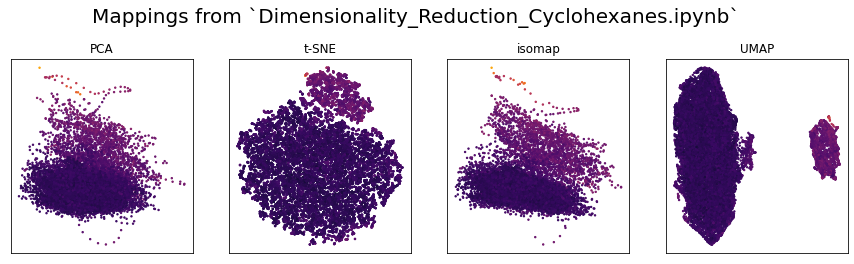

In [94]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

for ax, rep, rep_name in zip(axes, [t_pca, t_tsne, t_iso, t_umap],
                             ['PCA', 't-SNE', 'isomap', 'UMAP']):

    ax.scatter(
        rep[:, 0],
        rep[:, 1],
        s=2,
        c=energy,
        cmap=cmap,
    )

    ax.set_title(rep_name, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

fig.subplots_adjust(top=0.8)
plt.suptitle('Mappings from `Dimensionality_Reduction_Cyclohexanes.ipynb`')
plt.show()

## Clustering

Before jumping in to clustering algorithms, let's first create the distance matrix and visualize it. We are using euclidean distance here.

In [99]:
def plot_clusters(clustering_algorithm, clustering_algorithm_name='', **kwds):

    fig, axes = plt.subplots(1, 5, figsize=(15, 4))

    for ax, rep, rep_name in zip(axes,
                                 [mean_soaps, t_pca, t_tsne, t_iso, t_umap], [
                                     'SOAP Vectors\n(Plotted along PC1&2)',
                                     'PCA', 't-SNE', 'isomap', 'UMAP'
                                 ]):
        alg = clustering_algorithm(**kwds)
        labels = alg.fit_predict(rep)
        np.maximum(labels, 0)

        nclusters = len(np.unique(labels))

        cmap = plt.get_cmap('tab10' if nclusters < 10 else 'tab20')
        norm = mpl.colors.BoundaryNorm(np.arange(-0.5, nclusters + 0.5),
                                       cmap.N)

        ax.scatter(
            rep[:, 0] if 'SOAP' not in rep_name else t_pca[:, 0],
            rep[:, 1] if 'SOAP' not in rep_name else t_pca[:, 1],
            s=2,
            c=labels,
            cmap=cmap,
            norm=norm,
        )

        plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                     ax=ax,
                     orientation='horizontal',
                     ticks=range(0, nclusters))

        ax.set_title(rep_name, fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.subplots_adjust(top=0.8)
    plt.suptitle(clustering_algorithm_name)

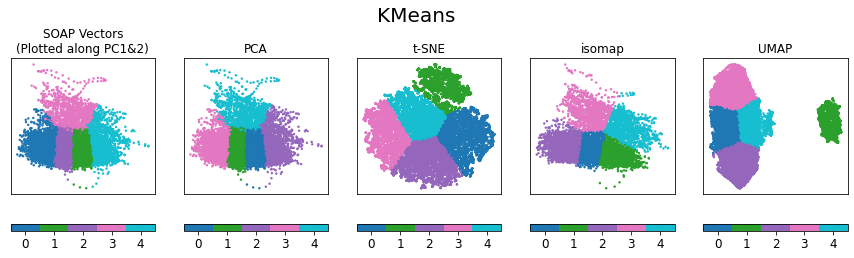

In [100]:
plot_clusters(cluster.KMeans, 'KMeans', **dict(n_clusters=5))

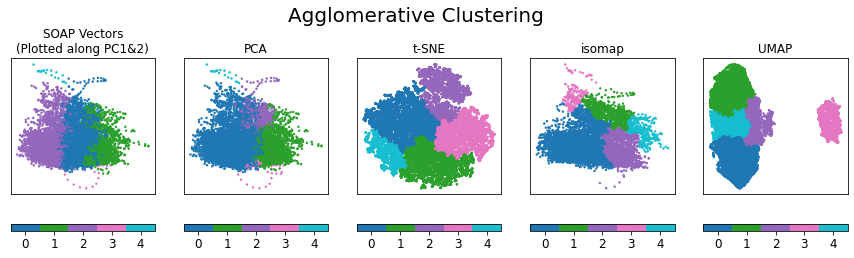

In [101]:
plot_clusters(cluster.AgglomerativeClustering, 'Agglomerative Clustering',
              **dict(n_clusters=5, linkage='complete'))

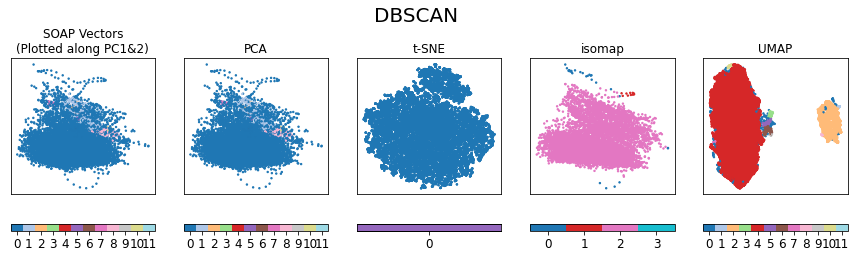

In [102]:
plot_clusters(cluster.DBSCAN, 'DBSCAN', **dict(eps=0.17, min_samples=10))

In [ ]:
plot_clusters(hdbscan.HDBSCAN, 'HDBSCAN', **dict(min_cluster_size=40))

In [ ]:
plot_clusters(cluster.MeanShift, 'MeanShift', **dict(cluster_all=True))